In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.validation  import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import train_test_split
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:

ratings = pd.read_csv(r"../input/ece219hw/ratings.csv")

print(ratings)

#build rating matrix?
# movie id --->   . . . (last col rating)
#user id going down

R_dataframe = ratings.pivot_table('rating', 'userId', 'movieId', fill_value=0)

#print(R_dataframe.head())

total_available_rating = len(ratings)
print(R_dataframe.shape)
total_possible_ratings = 610 * 9724
sparsity = total_available_rating / total_possible_ratings

print('Sparsity = ' +str(sparsity))

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
(610, 9724)
Sparsity = 0.016999683055613623


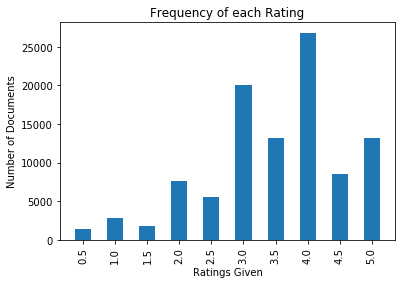

In [3]:
#question 2


R_matrix = R_dataframe.astype('int')
ratings_numbers = [0.5, 1.0, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

#need 5.5 to include 5 on the edge of the plot
ratings_axis = [0.5, 1.0, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0, 5.5]

plt.title("Frequency of each Rating")
plt.xticks(ticks=ratings_numbers, rotation='vertical')
plt.xlabel("Ratings Given")
#plt.yticks(np.arange(0,701,100))
plt.ylabel("Number of Documents")
#plt.bar(unique_categories, counts, align='center', tick_label=train_dataset.target_names)
plt.hist(ratings.rating, bins=ratings_axis, align='left', rwidth=0.5)

plt.show()



movieId
1         214
2         109
3          51
4           7
5          48
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Length: 9724, dtype: int64


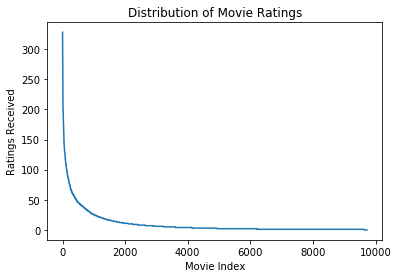

In [4]:
#question 3 - distribution of ratings among movies

movie_ratings_count = np.sum(R_matrix!=0, axis=0)

print(movie_ratings_count)

sorted_ratings = np.sort(movie_ratings_count)[::-1]


plt.plot(sorted_ratings)
plt.xlabel("Movie Index")
plt.ylabel("Ratings Received")
plt.title("Distribution of Movie Ratings")
plt.show()



movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1             4       0       4       0       0       4       0       0   
2             0       0       0       0       0       0       0       0   
3             0       0       0       0       0       0       0       0   
4             0       0       0       0       0       0       0       0   
5             4       0       0       0       0       0       0       0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
606           2       0       0       0       0       0       2       0   
607           4       0       0       0       0       0       0       0   
608           2       2       2       0       0       0       0       0   
609           3       0       0       0       0       0       0       0   
610           5       0       0       0       0       5       0       0   

movieId  9       10     

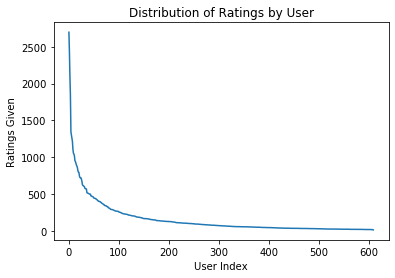

In [5]:
#question 4 - distribution of ratings among users
print(R_matrix)

user_ratings_count = np.sum(R_matrix!=0, axis=1)

print(user_ratings_count)

sorted_ratings = np.sort(user_ratings_count)[::-1]


plt.plot(sorted_ratings)
plt.xlabel("User Index")
plt.ylabel("Ratings Given")
plt.title("Distribution of Ratings by User")
plt.show()

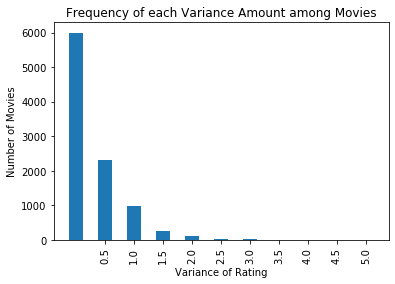

In [6]:
#question 5 - explain in report
#question 6 - compute variance of rating values received by each movie, plot variance



R_dataframe_var = ratings.pivot_table('rating', 'userId', 'movieId')
movie_rating_var = np.var(R_dataframe_var,axis=0)

ratings_axis_var = [0, 0.5, 1.0, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0, 5.5]


plt.title("Frequency of each Variance Amount among Movies")
plt.xticks(ticks=ratings_numbers, rotation='vertical')
plt.xlabel("Variance of Rating")
plt.ylabel("Number of Movies")
#plt.bar(unique_categories, counts, align='center', tick_label=train_dataset.target_names)
plt.hist(movie_rating_var, bins=ratings_axis_var, align='left', rwidth=0.5)

plt.show()

In [ ]:
# question 7
# question 8
# question 9

#explain in report

In [ ]:
# question 10

reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(r"../input/ece219hw/ratings.csv", reader=reader)

RMSE = []
MAE = []

for k in range(2,101,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    cv = cross_validate(knn, data, measures=['RMSE','MAE'],cv=10, verbose=False)
    RMSE.append(np.mean(cv['test_rmse']))
    MAE.append(np.mean(cv['test_mae']))

In [ ]:
k_axis = range(2,101,2)
plt.plot(k_axis, RMSE)
plt.title("Average RMSE vs k")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_axis, MAE)
plt.title("Average MAE vs k")
plt.xlabel("k values")
plt.ylabel("Average MAE")
plt.show()

#find minimum k and steady state values - question 11
RMSE_min_k = 2
MAE_min_k = 2

for k in range(1, 49):
    if(abs(RMSE[k] - RMSE[k+1]) < 0.0001):
        RMSE_min_k = k
        break
        
for k in range(1, 49):
    if(abs(MAE[k] - MAE[k+1]) < 0.0001):
        MAE_min_k = k
        break
        
RMSE_steady_state = RMSE[RMSE_min_k]
print("Minimum K for RMSE is: " +str(2*RMSE_min_k))
print("Steady state value for RMSE is: " +str(RMSE_steady_state))

MAE_steady_state = MAE[MAE_min_k]
print("Minimum K for MAE is: " +str(2*MAE_min_k))
print("Steady state value for MAE is: " +str(MAE_steady_state))


In [ ]:
#question 11 alternative
#or just eyeball k = 20 or 22
RMSE_steady_state = RMSE[10]
print("Minimum K for RMSE is: " +str(20))
print("Steady state value for RMSE is: " +str(RMSE_steady_state))

MAE_steady_state = MAE[10]
print("Minimum K for MAE is: " +str(20))
print("Steady state value for MAE is: " +str(MAE_steady_state))

In [ ]:
#question 12

#movie_ratings_count = np.sum(R_matrix!=0, axis=0)
#reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
#data = Dataset.load_from_file(r"C:\Users\Ryan\Desktop\ECE 219\ml-latest-small/ratings.csv", reader=reader)

movie_ID = list(R_dataframe)

def trim_movie_popular(input_testset, ratings_count):
    # find the pop index
    R_matrix_pop_index = list(np.where(ratings_count > 2))[0]
    
    popular_movie_index = []
    for i in range(len(R_matrix_pop_index)):
        popular_movie_index.append(movie_ID[R_matrix_pop_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in popular_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_popular = []
for k in range(2,101,2):
    knn = KNNWithMeans(k=k, sim_options={'name': 'pearson'})
    RMSE_temp = []
    for trainset, testset in kf.split(data):
        knn.fit(trainset)
        popular_trimmed_test = trim_movie_popular(testset, movie_ratings_count )
        predictions = knn.test(popular_trimmed_test)
        # Compute and print Root Mean Squared Error
        RMSE_temp.append(accuracy.rmse(predictions, verbose=False))
    RMSE_popular.append(np.mean(RMSE_temp))
    
k_axis = range(2,101,2)
plt.plot(k_axis, RMSE_popular)
plt.title("Average RMSE vs k for Popular Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

In [ ]:
#question 13 - unpopular

#movie_ratings_count = np.sum(R_matrix!=0, axis=0)
#reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
#data = Dataset.load_from_file(r"C:\Users\Ryan\Desktop\ECE 219\ml-latest-small/ratings.csv", reader=reader)

movie_ID = list(R_dataframe)

def trim_movie_unpopular(input_testset, ratings_count):
    R_matrix_unpop_index = list(np.where(ratings_count <= 2))[0]
    
    unpopular_movie_index = []
    for i in range(len(R_matrix_unpop_index)):
        unpopular_movie_index.append(movie_ID[R_matrix_unpop_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in unpopular_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_unpopular = []
for k in range(2,101,2):
    knn = KNNWithMeans(k=k, sim_options={'name': 'pearson'})
    RMSE_temp_unpop = []
    for trainset, testset in kf.split(data):
        knn.fit(trainset)
        unpopular_trimmed_test = trim_movie_unpopular(testset, movie_ratings_count )
        predictions = knn.test(unpopular_trimmed_test)
        # Compute and print Root Mean Squared Error
        RMSE_temp_unpop.append(accuracy.rmse(predictions, verbose=False))
    RMSE_unpopular.append(np.mean(RMSE_temp_unpop))
    
##typo below - code is repeated in next block    
k_axis = range(2,101,2)
plt.plot(k_axis, RMSE_unpopular)
plt.title("Average RMSE vs k for Unpopular Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

In [ ]:
#question 14 - high variance and at least 5 ratings

#movie_ratings_count = np.sum(R_matrix!=0, axis=0)
#reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
#data = Dataset.load_from_file(r"C:\Users\Ryan\Desktop\ECE 219\ml-latest-small/ratings.csv", reader=reader)

movie_ID = list(R_dataframe)
R_dataframe_var = ratings.pivot_table('rating', 'userId', 'movieId')
movie_rating_var = np.var(R_dataframe_var,axis=0)
movie_var_list = list(movie_rating_var)

def trim_movie_variance(input_testset, ratings_count, movie_variance_list):
    #first filter by 5+ ratings
    R_matrix_var_index = list(np.where(ratings_count >= 5))[0]
    
    variance_movie_index = []
    for i in range(len(R_matrix_var_index)):
        #filter for high variance
        if movie_variance_list[R_matrix_var_index[i]] >= 2: 
            variance_movie_index.append(movie_ID[R_matrix_var_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in variance_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_variance = []
for k in range(2,101,2):
    knn = KNNWithMeans(k=k, sim_options={'name': 'pearson'})
    RMSE_temp_variance = []
    for trainset, testset in kf.split(data):
        knn.fit(trainset)
        variance_trimmed_test = trim_movie_variance(testset, movie_ratings_count, movie_var_list)
        predictions = knn.test(variance_trimmed_test)
        RMSE_temp_variance.append(accuracy.rmse(predictions, verbose=False))
    RMSE_variance.append(np.mean(RMSE_temp_variance))
    
##typo below - code is repeated in next block    
k_axis = range(2,101,2)
plt.plot(k_axis, RMSE_variance)
plt.title("Average RMSE vs k for High Variance Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

In [ ]:
# question 12,13,14 catch-all
# print minimum RMSE for each

print("Minimum average RMSE for Popular movies is: " + str(min(RMSE_popular)))
print("Minimum average RMSE for Unpopular movies is: " + str(min(RMSE_unpopular)))
print("Minimum average RMSE for High Variance movies is: " + str(min(RMSE_variance)))

In [ ]:
# question 15 - plot ROC
# k = 20 in both cases
from surprise.model_selection import train_test_split
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

thresholds = [2.5, 3, 3.5, 4]
trainset, testset = train_test_split(data, test_size=0.1)

for threshold in thresholds:
    knn = KNNWithMeans(k=20, sim_options={'name': 'pearson'})
# train and test algorithm
    knn.fit(trainset)
    predicted = knn.test(testset)

    actual_y = []
    pred_y = []
    for i in range(len(predicted)):
        pred_y.append(predicted[i].est)
        if testset[i][2] >= threshold:
            actual_y.append(1)
        else:
            actual_y.append(0)
    

    fpr, tpr, thresholds = roc_curve(actual_y, pred_y)
    AUC = roc_auc_score(actual_y, pred_y)
    plt.plot(fpr,tpr)
    plt.title('ROC curve with threshold = %f, AUC score = %.5f' %(threshold, AUC))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [ ]:
#question 16 answer in report

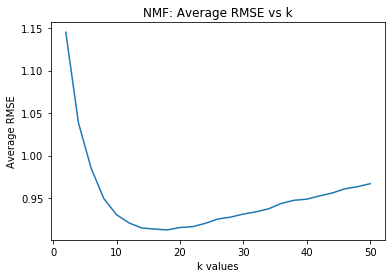

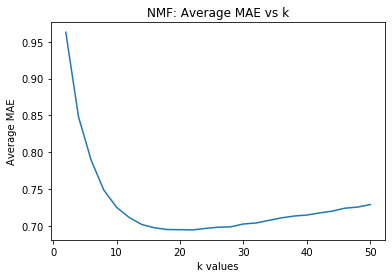

In [22]:
# question 17 NNMF k from 2 to 50, step size 2
from surprise.prediction_algorithms.matrix_factorization import NMF

reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(r"../input/ece219hw/ratings.csv", reader=reader)
k_range = range(2,51,2)

    
RMSE_nmf = []
MAE_nmf = []

for k in range(2,51,2):
    nmf = NMF(n_factors=k)
    cv = cross_validate(nmf, data, measures=['RMSE','MAE'],cv=10, verbose=False)
    RMSE_nmf.append(np.mean(cv['test_rmse']))
    MAE_nmf.append(np.mean(cv['test_mae']))
    
plt.plot(k_range, RMSE_nmf)
plt.title("NMF: Average RMSE vs k")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_range, MAE_nmf)
plt.title("NMF: Average MAE vs k")
plt.xlabel("k values")
plt.ylabel("Average MAE")
plt.show()


In [23]:
#question 18

RMSE_nmf_min_k = 2
MAE_nmf_min_k = 2

RMSE_nmf_min = 100
MAE_nmf_min = 100
for k in range(1, 24):
    if(RMSE_nmf[k] < RMSE_nmf_min):
        RMSE_nmf_min_k = k
        RMSE_nmf_min = RMSE_nmf[k]
for k in range(1, 24):
    if(MAE_nmf[k] < MAE_nmf_min):
        MAE_nmf_min_k = k
        MAE_nmf_min = MAE_nmf[k]
        
min_avg_RMSE = RMSE_nmf[RMSE_nmf_min_k]
print("NMF: Minimum K for RMSE is: " +str(2*RMSE_nmf_min_k))
print("NMF: Minimum average value for RMSE is: " +str(min_avg_RMSE))

min_avg_MAE = MAE_nmf[MAE_nmf_min_k]
print("NMF: Minimum K for MAE is: " +str(2*MAE_nmf_min_k))
print("NMF: Steady state value for MAE is: " +str(min_avg_MAE))

#number of movie genres from the readme is 19 (including no genre)
#RMSE = 16
#MAE = 18 matches the number of non-empty genres

NMF: Minimum K for RMSE is: 16
NMF: Minimum average value for RMSE is: 0.9124508092961803
NMF: Minimum K for MAE is: 20
NMF: Steady state value for MAE is: 0.6943228100005799


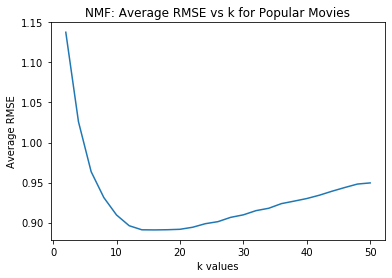

NMF: Minimum K for RMSE is: 14
NMF: Minimum average value for RMSE is: 0.8909147424029789


In [24]:
#question 19

movie_ratings_count = np.sum(R_matrix!=0, axis=0)
reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(r"../input/ece219hw/ratings.csv", reader=reader)

movie_ID = list(R_dataframe)
R_dataframe_var = ratings.pivot_table('rating', 'userId', 'movieId')
movie_rating_var = np.var(R_dataframe_var,axis=0)
movie_var_list = list(movie_rating_var)


def trim_movie_popular(input_testset, ratings_count):
    # find the pop index
    R_matrix_pop_index = list(np.where(ratings_count > 2))[0]
    
    popular_movie_index = []
    for i in range(len(R_matrix_pop_index)):
        popular_movie_index.append(movie_ID[R_matrix_pop_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in popular_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_nmf_popular = []
for k in range(2,51,2):
    nmf = NMF(n_factors=k)
    RMSE_nmf_temp = []
    for trainset, testset in kf.split(data):
        nmf.fit(trainset)
        popular_nmf_trimmed_test = trim_movie_popular(testset, movie_ratings_count)
        predictions = nmf.test(popular_nmf_trimmed_test)
        RMSE_nmf_temp.append(accuracy.rmse(predictions, verbose=False))
    RMSE_nmf_popular.append(np.mean(RMSE_nmf_temp))
    
k_axis = range(2,51,2)
plt.plot(k_axis, RMSE_nmf_popular)
plt.title("NMF: Average RMSE vs k for Popular Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

RMSE_nmf_pop_min = 100
RMSE_nmf_pop_min_k = 2

for k in range(1, 24):
    if(RMSE_nmf_popular[k] < RMSE_nmf_pop_min):
        RMSE_nmf_pop_min_k = k
        RMSE_nmf_pop_min = RMSE_nmf_popular[k]
        
        
min_avg_pop_RMSE = RMSE_nmf_popular[RMSE_nmf_pop_min_k]
print("NMF: Minimum K for RMSE is: " +str(2*RMSE_nmf_pop_min_k))
print("NMF: Minimum average value for RMSE is: " +str(min_avg_pop_RMSE))

In [ ]:
#question 20


def trim_movie_unpopular(input_testset, ratings_count):
    R_matrix_unpop_index = list(np.where(ratings_count <= 2))[0]
    
    unpopular_movie_index = []
    for i in range(len(R_matrix_unpop_index)):
        unpopular_movie_index.append(movie_ID[R_matrix_unpop_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in unpopular_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_nmf_unpop = []
for k in range(2,51,2):
    nmf = NMF(n_factors=k)
    RMSE_temp_unpop = []
    for trainset, testset in kf.split(data):
        nmf.fit(trainset)
        unpop_nmf_trimmed_test = trim_movie_unpopular(testset, movie_ratings_count )
        predictions = nmf.test(unpop_nmf_trimmed_test)
        # Compute and print Root Mean Squared Error
        RMSE_temp_unpop.append(accuracy.rmse(predictions, verbose=False))
    RMSE_nmf_unpop.append(np.mean(RMSE_temp_unpop))
    
k_axis = range(2,51,2)
plt.plot(k_axis, RMSE_nmf_unpop)
plt.title("NMF: Average RMSE vs k for Unpopular Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

RMSE_nmf_unpop_min = 100
RMSE_nmf_unpop_min_k = 2
for k in range(1, 24):
    if(RMSE_nmf_unpop[k] < RMSE_nmf_unpop_min):
        RMSE_nmf_unpop_min_k = k
        RMSE_nmf_unpop_min = RMSE_nmf_unpop[k]
        
        
min_avg_unpop_RMSE = RMSE_nmf_unpop[RMSE_nmf_unpop_min_k]
print("NMF: Minimum K for RMSE is: " +str(2*RMSE_nmf_unpop_min_k))
print("NMF: Minimum average value for RMSE is: " +str(min_avg_unpop_RMSE))

In [ ]:
#question 21


def trim_movie_variance(input_testset, ratings_count, movie_variance_list):
    #first filter by 5+ ratings
    R_matrix_var_index = list(np.where(ratings_count >= 5))[0]
    
    variance_movie_index = []
    for i in range(len(R_matrix_var_index)):
        #filter for high variance
        if movie_variance_list[R_matrix_var_index[i]] >= 2: 
            variance_movie_index.append(movie_ID[R_matrix_var_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in variance_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_variance = []
for k in range(2,51,2):
    nmf = NMF(n_factors=k)
    RMSE_temp_variance = []
    for trainset, testset in kf.split(data):
        nmf.fit(trainset)
        variance_trimmed_test = trim_movie_variance(testset, movie_ratings_count, movie_var_list)
        predictions = nmf.test(variance_trimmed_test)
        RMSE_temp_variance.append(accuracy.rmse(predictions, verbose=False))
    RMSE_variance.append(np.mean(RMSE_temp_variance))
    
k_axis = range(2,51,2)
plt.plot(k_axis, RMSE_variance)
plt.title("Average RMSE vs k for High Variance Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

In [ ]:
# question 22

#copied from 10?

#use 16 or 18

from surprise.model_selection import train_test_split
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(r"../input/ece219hw/ratings.csv", reader=reader)


thresholds = [2.5, 3, 3.5, 4]
trainset, testset = train_test_split(data, test_size=0.1)

for threshold in thresholds:
    nmf = NMF(n_factors=18)
# train and test algorithm
    nmf.fit(trainset)
    predicted = nmf.test(testset)

    actual_y = []
    pred_y = []
    for i in range(len(predicted)):
        pred_y.append(predicted[i].est)
        if testset[i][2] >= threshold:
            actual_y.append(1)
        else:
            actual_y.append(0)
    

    fpr, tpr, thresholds = roc_curve(actual_y, pred_y)
    AUC = roc_auc_score(actual_y, pred_y)
    plt.plot(fpr,tpr)
    plt.title('ROC curve with threshold = %f, AUC score = %.5f' %(threshold, AUC))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [8]:
#question 23
reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
all_movies = Dataset.load_from_file(r"../input/ece219hw/ratings.csv", reader=reader)

csv_movies = pd.read_csv(r"../input/movies/movies.csv", names = ['movieid', 'title', 'genres'],header=0)

train_set, test_set = train_test_split(all_movies, test_size=0.1)
nmf = NMF(n_factors=20, biased=False)
nmf.fit(train_set)
factors = nmf.qi
for k in range(0,21):
    movies = factors[:,k]
    moviesEntry = []
    for i in range(len(movies)):
        moviesEntry.append((i, movies[i]))
    moviesEntry.sort(key = lambda x:x[1], reverse=True)
    print("Column entries for k = " +str(k))
    for entries in moviesEntry[0:10]:
        print(csv_movies['genres'][entries[0]])

Column entries for k = 0
Comedy|Romance
Comedy|Drama
Adventure|Drama|Thriller
Comedy
Comedy|Romance
Comedy|Drama|Romance|War
Comedy
Documentary
Drama
Comedy|Horror
Column entries for k = 1
Crime|Drama|Thriller
Drama|Fantasy|Mystery
Action|Drama
Adventure|Animation|Children|Comedy|Fantasy|War
Comedy|Drama|War
Comedy|Drama|Thriller
Drama|Romance
Crime|Drama
Horror
Action|Comedy
Column entries for k = 2
Drama|Horror|Mystery|Thriller
Romance|Thriller
Adventure|Comedy
Adventure|Children|Comedy
Comedy|Romance
Action
Drama|Romance
Adventure|Children
Horror|Thriller
Comedy
Column entries for k = 3
Comedy
Horror|Sci-Fi|Thriller
Drama|War
Drama|Sci-Fi
Adventure|Animation|Children|Drama
Comedy|Horror|Sci-Fi|Thriller
Comedy|Crime
Animation|Children|Musical
Action|Sci-Fi
Drama
Column entries for k = 4
Comedy|Drama
Comedy|Drama
Action|Thriller
Drama|Fantasy|Mystery
Action|Adventure
Action|Adventure|Comedy|Thriller
Comedy|Crime|Drama|Mystery
Comedy
Mystery|Thriller
Comedy|Crime
Column entries for k =

IndexError: index 20 is out of bounds for axis 1 with size 20

In [ ]:
#q23 alternative

#reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
all_movies = Dataset.load_from_file(r"../input/ece219hw/ratings.csv", reader=reader)
#csv_movies = pd.read_csv(r"../input/movies/movies.csv", names = ['movieid', 'title', 'genres'],header=0)
import csv

with open(r"../input/movies/movies.csv", 'r', encoding='utf8') as f:
    reader = csv.reader(f, delimiter=',', quotechar='"')
    next(reader, None)
    csv_movies = {int(movie[0]): movie[2] for movie in reader}
  
reader = Reader(sep=',', rating_scale=(0.0, 5.0), skip_lines=1)

nmf = NMF(n_factors=20)
train_all_movies = all_movies.build_full_trainset()
nmf.fit(train_all_movies)

factors = nmf.qi
for c in range(20):
    print("Top 10 Values in Column " +str(c))
    sort_indices = np.argsort(-1*factors[:,c])[0:10]
    print(factors[sort_indices[0:10],c])
    print("Genres of Movies:")
    for i in sort_indices:
        print(csv_movies[int(train_all_movies.to_raw_iid(i))])

    print("")

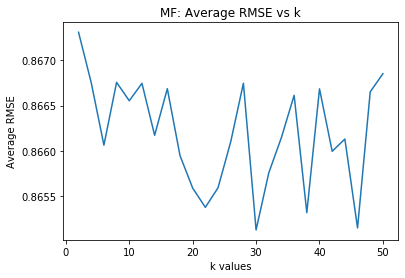

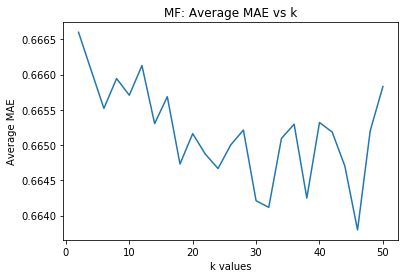

MF: Minimum K for RMSE is: 28
MF: Minimum average value for RMSE is: 0.8651315814026251
MF: Minimum K for MAE is: 44
MF: Minimum average value for MAE is: 0.6637960398236242


In [14]:
#question 24

from surprise.prediction_algorithms.matrix_factorization import SVD

reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(r"../input/ece219hw/ratings.csv", reader=reader)

RMSE_mf_bias = []
MAE_mf_bias = []

for k in range(2,51,2):
    mf = SVD(n_factors=k, biased=True)
    cv = cross_validate(mf, data ,measures=['RMSE','MAE'],cv=10, verbose=False)
    RMSE_mf_bias.append(np.mean(cv['test_rmse']))
    MAE_mf_bias.append(np.mean(cv['test_mae']))
    
k_bias_axis = range(2,51,2)
plt.plot(k_bias_axis, RMSE_mf_bias)
plt.title("MF: Average RMSE vs k")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()


plt.plot(k_bias_axis, MAE_mf_bias)
plt.title("MF: Average MAE vs k")
plt.xlabel("k values")
plt.ylabel("Average MAE")
plt.show()


#question 25
RMSE_mf_bias_min = 100
RMSE_mf_bias_min_k = 2
for k in range(1, 24):
    if(RMSE_mf_bias[k] < RMSE_mf_bias_min):
        RMSE_mf_bias_min_k = k
        RMSE_mf_bias_min = RMSE_mf_bias[k]
        
        
min_avg_bias_RMSE = RMSE_mf_bias[RMSE_mf_bias_min_k]
print("MF: Minimum K for RMSE is: " +str(2*RMSE_mf_bias_min_k))
print("MF: Minimum average value for RMSE is: " +str(min_avg_bias_RMSE))

MAE_mf_bias_min = 100
MAE_mf_bias_min_k = 2
for k in range(1, 24):
    if(MAE_mf_bias[k] < MAE_mf_bias_min):
        MAE_mf_bias_min_k = k
        MAE_mf_bias_min = MAE_mf_bias[k]
        
        
min_avg_bias_MAE = MAE_mf_bias[MAE_mf_bias_min_k]
print("MF: Minimum K for MAE is: " +str(2*MAE_mf_bias_min_k))
print("MF: Minimum average value for MAE is: " +str(min_avg_bias_MAE))

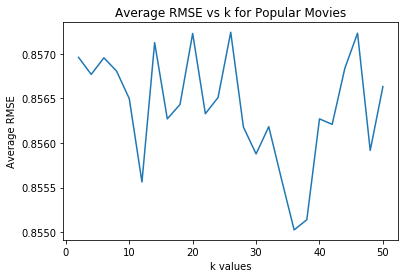

MF: Minimum average RMSE for Popular movies is: 0.8550256518827142


In [15]:
#question 26 - popular trimmed dataset, k from 2 to 50, minimum RMSE

movie_ratings_count = np.sum(R_matrix!=0, axis=0)
#reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))

movie_ID = list(R_dataframe)

def trim_movie_popular(input_testset, ratings_count):
    # find the pop index
    R_matrix_pop_index = list(np.where(ratings_count > 2))[0]
    
    popular_movie_index = []
    for i in range(len(R_matrix_pop_index)):
        popular_movie_index.append(movie_ID[R_matrix_pop_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in popular_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_bias_popular = []
for k in range(2,51,2):
    mf = SVD(n_factors=k, biased=True)
    RMSE_bias_temp = []
    for trainset, testset in kf.split(data):
        mf.fit(trainset)
        popular_trimmed_test = trim_movie_popular(testset, movie_ratings_count)
        predictions = mf.test(popular_trimmed_test)
        RMSE_bias_temp.append(accuracy.rmse(predictions, verbose=False))
    RMSE_bias_popular.append(np.mean(RMSE_bias_temp))
    
k_axis = range(2,51,2)
plt.plot(k_axis, RMSE_bias_popular)
plt.title("Average RMSE vs k for Popular Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

print("MF: Minimum average RMSE for Popular movies is: " + str(min(RMSE_bias_popular)))

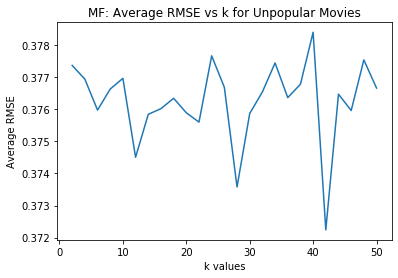

NMF: Minimum average value for RMSE is: 0.37223776515815693


In [17]:
#question 27 - unpop

#question 20


def trim_movie_unpopular(input_testset, ratings_count):
    R_matrix_unpop_index = list(np.where(ratings_count <= 2))[0]
    
    unpopular_movie_index = []
    for i in range(len(R_matrix_unpop_index)):
        unpopular_movie_index.append(movie_ID[R_matrix_unpop_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in unpopular_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_mf_bias_unpop = []
for k in range(2,51,2):
    mf = SVD(n_factors=k, biased=True)
    RMSE_temp_unpop = []
    for trainset, testset in kf.split(data):
        mf.fit(trainset)
        unpop_mf_trimmed_test = trim_movie_unpopular(testset, movie_ratings_count)
        predictions = nmf.test(unpop_mf_trimmed_test)
        RMSE_temp_unpop.append(accuracy.rmse(predictions, verbose=False))
    RMSE_mf_bias_unpop.append(np.mean(RMSE_temp_unpop))
    
k_axis = range(2,51,2)
plt.plot(k_axis, RMSE_mf_bias_unpop)
plt.title("MF: Average RMSE vs k for Unpopular Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

print("NMF: Minimum average value for RMSE is: " +str(min(RMSE_mf_bias_unpop)))

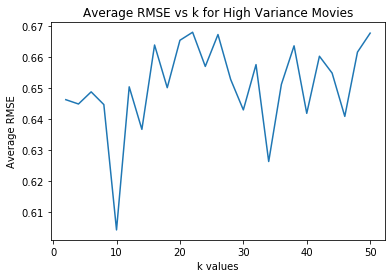

NMF: Minimum average value for RMSE is: 0.604258453044722


In [21]:
#question 28

movie_rating_var = np.var(R_dataframe_var,axis=0)
movie_var_list = list(movie_rating_var)

def trim_movie_variance(input_testset, ratings_count, movie_variance_list):
    #first filter by 5+ ratings
    R_matrix_var_index = list(np.where(ratings_count >= 5))[0]
    
    variance_movie_index = []
    for i in range(len(R_matrix_var_index)):
        #filter for high variance
        if movie_variance_list[R_matrix_var_index[i]] >= 2: 
            variance_movie_index.append(movie_ID[R_matrix_var_index[i]])

    trimmed_testset = []
    for j in range(len(input_testset)):
        if int(input_testset[j][1]) in variance_movie_index:
            trimmed_testset.append(input_testset[j])
    return trimmed_testset


kf = KFold(n_splits=10)
RMSE_bias_variance = []

for k in range(2,51,2):
    mf = SVD(n_factors=k, biased=True)
    RMSE_bias_temp_variance = []
    for trainset, testset in kf.split(data):
        mf.fit(trainset)
        variance_trimmed_test = trim_movie_variance(testset, movie_ratings_count, movie_var_list)
        predictions = nmf.test(variance_trimmed_test)
        RMSE_bias_temp_variance.append(accuracy.rmse(predictions, verbose=False))
    RMSE_bias_variance.append(np.mean(RMSE_bias_temp_variance))
    
k_axis = range(2,51,2)
plt.plot(k_axis, RMSE_bias_variance)
plt.title("Average RMSE vs k for High Variance Movies")
plt.xlabel("k values")
plt.ylabel("Average RMSE")
plt.show()

print("NMF: Minimum average value for RMSE is: " +str(min(RMSE_bias_variance)))

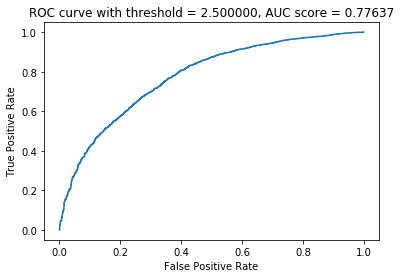

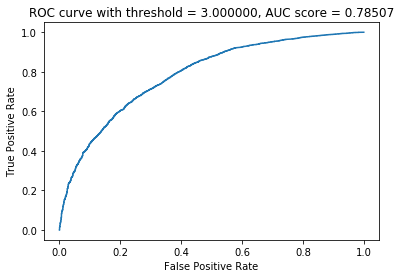

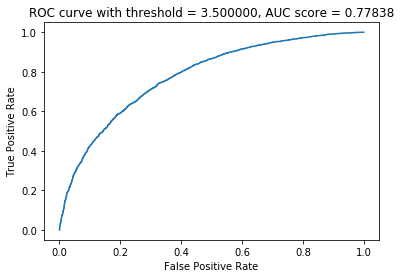

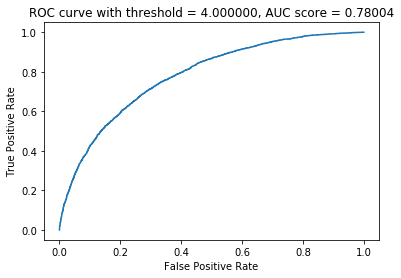

In [20]:
#question 29

#select k = 28 for rmse
from surprise.model_selection import train_test_split
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

thresholds = [2.5, 3, 3.5, 4]
trainset, testset = train_test_split(data, test_size=0.1)

for threshold in thresholds:
    mf = SVD(n_factors=28, biased=True)
# train and test algorithm
    mf.fit(trainset)
    predicted = mf.test(testset)

    actual_y = []
    pred_y = []
    for i in range(len(predicted)):
        pred_y.append(predicted[i].est)
        if testset[i][2] >= threshold:
            actual_y.append(1)
        else:
            actual_y.append(0)
    

    fpr, tpr, thresholds = roc_curve(actual_y, pred_y)
    AUC = roc_auc_score(actual_y, pred_y)
    plt.plot(fpr,tpr)
    plt.title('ROC curve with threshold = %f, AUC score = %.5f' %(threshold, AUC))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()